# Geometric Datasets: Exeter

Improved version:
* F

## Description

Code for creating the geometric datasets for the Two-Objective Design/Resilience networks from [Exeter Benchmarks](https://emps.exeter.ac.uk/engineering/research/cws/resources/benchmarks/design-resiliance-pareto-fronts/) 

*Small Problems*
* Two-Reservoir Network
* Two-Loop Network
* BakRyan Network

*Medium Problems*
* New York Tunnel Network
* Blacksburg Network
* Hanoi Network

*Intemediate Problems*
* Fossolo Network
* Pescara Network

*Large Problems*
* Modena Network
* Balerma Irrigation Network

*GoYang Network and Exeter Network were excluded because they had accessories (Pumps and valves) not yet contemplated for the extent of this exercise. 


## Imports

### Basic

In [31]:
import os
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import winsound

### Custom functions

In [32]:
#Custom .py file
#from PrasadParkIndex import *
from res_index import *

### PyTorch and PyG

In [33]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
#from torch_geometric.datasets import TUDataset

### DeepSNAP

In [34]:
# from deepsnap.graph import Graph as dSNAP_Graph
# from deepsnap.dataset import GraphDataset as dSNAP_GraphDS

### Plotly

In [35]:
import plotly.graph_objects as go

## Loading inp file

In [36]:
# Create a water network model
def load_inp(inp_file_path):
    wn_WDS = wntr.network.WaterNetworkModel(inp_file_path)

    # Plot the network
    wntr.graphics.plot_network(wn_WDS, title=wn_WDS.name)

    # Simulate hydraulics
    sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
    results_WDS = sim_WDS.run_sim()
    
    return(wn_WDS, sim_WDS, results_WDS)

### Name of the Network 

Choices:
\['BAK', 'BIN', 'BLA', 'FOS', 'HAN', 'MOD', 'NYT', 'PES', 'TLN', 'TRN']

In [37]:
name_WDS = 'FOS'

#Read the Network info
WDS_info = pd.read_csv('./networks/Exeter/'+name_WDS+'_info.csv', dtype = {'NodeID': str} )

WDS_info.head()

,D,Cost,NodeID,MinPressure_m,UNITS_TO_M
0,16.0,0.38,1,40,0.001
1,20.4,0.56,2,40,NaN
2,26.0,0.88,3,40,NaN
3,32.6,1.35,4,40,NaN
4,40.8,2.02,5,40,NaN


In [38]:
#Transform the min. pressure of the nodes into a pandas dataframe
min_pres = WDS_info[['NodeID', 'MinPressure_m']].dropna()
min_pres = min_pres.set_index('NodeID')

#Obtain the conversion factor for the diameters (Some are given in inches, meters, or mm)
UNIT_TO_M = WDS_info['UNITS_TO_M'].dropna().item()

### Load the inp file

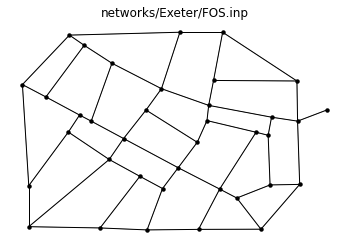

In [39]:
path= 'networks/Exeter/'+name_WDS+'.inp'
wn_WDS, _, _ = load_inp(path)
#wn_WDS = wntr.network.WaterNetworkModel(path)

In [40]:
names = ['BAK', 'BIN', 'BLA', 'FOS', 'HAN', 'MOD', 'NYT', 'PES', 'TLN', 'TRN']
seeds = [132, 65464, 8754, 465542, 13211, 9874545, 12, 9872, 6781, 978888]
dict_seeds =dict(zip(names, seeds))

num_pipes = wn_WDS.num_pipes

avail_diams = list(WDS_info.D.dropna()) #[6, 8, 10, 12, 14] #inches
pipe_names = wn_WDS.link_name_list

seed = dict_seeds[name_WDS] #Trial seed: 4345
np.random.seed(seed)



In [41]:
avail_diams

[16.0,
 20.4,
 26.0,
 32.6,
 40.8,
 51.4,
 61.4,
 73.6,
 90.0,
 102.2,
 114.6,
 130.8,
 147.2,
 163.6,
 184.0,
 204.6,
 229.2,
 257.8,
 290.6,
 327.4,
 368.2,
 409.2]

## Dataset Creation

### NetworkX representation


Information on nodes and edges

In [42]:
def from_wntr_to_nx(wn):
    wn_links = list(wn.links())
    wn_nodes = list(wn.nodes())
    
    G_WDS = wn.get_graph() # directed multigraph
    uG_WDS = G_WDS.to_undirected() # undirected
    sG_WDS = nx.Graph(uG_WDS) #Simple graph  
    
    i=0
    for (u, v, wt) in sG_WDS.edges.data():
        assert isinstance(wn_links[i][1], wntr.network.elements.Pipe), "The link is not a pipe"
        sG_WDS[u][v]['diameter'] =  wn_links[i][1].diameter
        sG_WDS[u][v]['length'] =    wn_links[i][1].length
        sG_WDS[u][v]['roughness'] = wn_links[i][1].roughness
        i+=1
    
    i=0
    for u in sG_WDS.nodes:
        
        if sG_WDS.nodes[u]['type'] == 'Junction': 
            sG_WDS.nodes[u]['ID'] =          wn_nodes[i][1].name
            sG_WDS.nodes[u]['type_1H'] =     0
            sG_WDS.nodes[u]['base_demand'] = list(wn_nodes[i][1].demand_timeseries_list)[0].base_value
            sG_WDS.nodes[u]['elevation'] =   wn_nodes[i][1].elevation
            sG_WDS.nodes[u]['base_head'] =   0
            
            
        elif sG_WDS.nodes[u]['type'] == 'Reservoir':
            sG_WDS.nodes[u]['ID'] =          wn_nodes[i][1].name
            sG_WDS.nodes[u]['type_1H'] =     1
            sG_WDS.nodes[u]['base_demand'] = 0
            sG_WDS.nodes[u]['elevation'] =   0
            sG_WDS.nodes[u]['base_head'] =   wn_nodes[i][1].base_head
        else:
            print(u)
            raise Exception('Only Junctions and Reservoirs so far')
            break
            
        i+=1

    return sG_WDS #df_nodes, df_links, sG_WDS



In [43]:
b = convert.from_networkx(a)

NameError: name 'a' is not defined

In [ ]:
# def from_wntr_to_geometric(wn):      
#     df_nodes, df_links, sG_WDS = from_wntr_to_pandas(wn)   # get pandas dataframes

#     # create torch data 
#     x = torch.tensor(df_nodes[['node_type','base_demand','elevation','base_head']].astype(float).values, dtype=torch.float)
#     pos = torch.tensor(df_nodes['coords'], dtype=torch.float)
#     pg_sG_WDS = convert.from_networkx(sG_WDS)
    
#     #edge_index = torch.tensor(COO_edges, dtype=torch.long)
#     edge_attr = torch.tensor(df_links[['length','diameter','roughness']].astype(float).values, dtype=torch.float)
#     data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

#     return data, df_nodes, df_links

In [ ]:
#data, df_nodes, df_links = from_wntr_to_geometric(wn_WDS)

In [ ]:
#results_WDS.node['pressure']

In [ ]:
# print(res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini'))

In [ ]:
p = [(i+1)/len(avail_diams) for i in range(len(avail_diams))]
p = [p[i]/sum(p) for i in range(len(p))]

### Loop for database generation

In [ ]:
#first_DB = []
np.random.seed(seed)

all_geom_data = [] # geometric data
fail_DB = []
N_iter = 20
sim=0
while len(all_geom_data)<N_iter and len(fail_DB)<N_iter:
    # echo on screen
    if sim % 50 == 0 or sim == N_iter-1:
        print(f'iter: {sim}')
  
    # assign diameters    
    new_diams = np.random.choice(avail_diams, num_pipes, replace= True, p = p)
    new_diams = new_diams * UNIT_TO_M
    
    for i in range(num_pipes):
        c_pipe = wn_WDS.get_link(pipe_names[i])
        c_pipe.diameter = new_diams[i]
    
    # run the simulation
    try:
    # Simulate hydraulics
        sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
        results_WDS = sim_WDS.run_sim()
        flowrate = 0 #There are no pumps
        
        # get resilience indexes  
        RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
        RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')


        # create Geometric Data 
        data = convert.from_networkx(from_wntr_to_nx(wn_WDS))

        
        #Add resilience indexes
        data.res_Todini = torch.tensor(RI_Todini)
        data.res_PP = torch.tensor(RI_PP)
        all_geom_data.append(data)
    
    except Exception as e:
        fail_row = [sim]
        fail_row.append(np.round(new_diams/UNIT_TO_M, 0))
        fail_row.append(wn_WDS)
        fail_row.append(e)
        print(e)
        fail_DB.append(fail_row)
    sim+=1
    

In [ ]:
print(len(all_geom_data), len(fail_DB))

In [ ]:
all_geom_data[-1]

In [ ]:
winsound.Beep(1000, 500)

In [ ]:
# folder
dir_path = os.getcwd()+'\{name}_Geom_DB_{num_iter}'.format(name = name_WDS, num_iter = N_iter)
print(dir_path)

In [ ]:
dataset = {}
dataset['info'] = 'Dataset for graph regression to compute '+name_WDS+' resilience index. Edge_attr = [Length, diameter, roughness] of every pipe, x =[Node type(junction 0, reservoir 1), Base demand (0 for reservoirs), elevation, base head(0 for junctions)]'
dataset['ngraphs'] = len(all_geom_data)
dataset['data'] = all_geom_data

In [ ]:
# save
try:
    os.mkdir(dir_path)    
    pickle.dump(dataset,open(f"{dir_path}/new_datasets/{name_WDS}_dataset.p", "wb" ))
except OSError:
    print ("Creation of the directory %s failed" % dir_path)
else:
    print ("Successfully created the directory %s " % dir_path)

In [ ]:
#pickle.dump(dataset,open(f"{dir_path}/{name_WDS}_dataset.p", "wb" ))

In [ ]:
#prueba = pickle.load(open(r'C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\BIN_Geom_DB_5000\BIN_dataset.p', 'rb'))

In [ ]:
prueba = pickle.load(open(f'{dir_path}/{name_WDS}_dataset.p', 'rb'))

In [ ]:
len(prueba['data'])

In [ ]:
res = []
for i in range(len(prueba['data'])):
    res.append(prueba['data'][i].res_PP)

In [ ]:
RI_PP_new = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
RI_Todini_new = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
RI_PP_old = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 30)
RI_Todini_old = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 30)

In [ ]:
RI_Todini_new, RI_PP_old

In [ ]:
np.array(res).max()

In [ ]:
RI_PP_old

In [ ]:
RI_PP_new

In [ ]:
#     RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
#     RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
    #RI_PP = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    #RI_Todini = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)

In [ ]:
res[0:10]

In [ ]:
prueba['data'][4997].edge_attr[:,1] #Diameters

In [ ]:
prueba['data'][0].edge_attr[:,1]/ UNIT_TO_M #Diameters